# Optical Character Recognition 

OCR is the concept of being able to extract text and other use information from images. With CodeNotes, the goal is to create a custom OCR that would be tailored towards coding and be able to read handwritten code and translate it into code. 

OpenCV was used to preprocess images, which is explained in greater detail later. Tensorflow was the crucial unit behind creating the Convolutional Neural Network (CNN). 

In [27]:
# Import necessary libraries

import cv2
import os
from glob import glob
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random


## Training

A local dataset was created by handwriting letters multiple times on Excalidraw to most closely replicate real life situations. Since Excalidraw is an online tool, using handwritten letters by pen and pencils would prove useless as most users would resort to a stylus or touch.

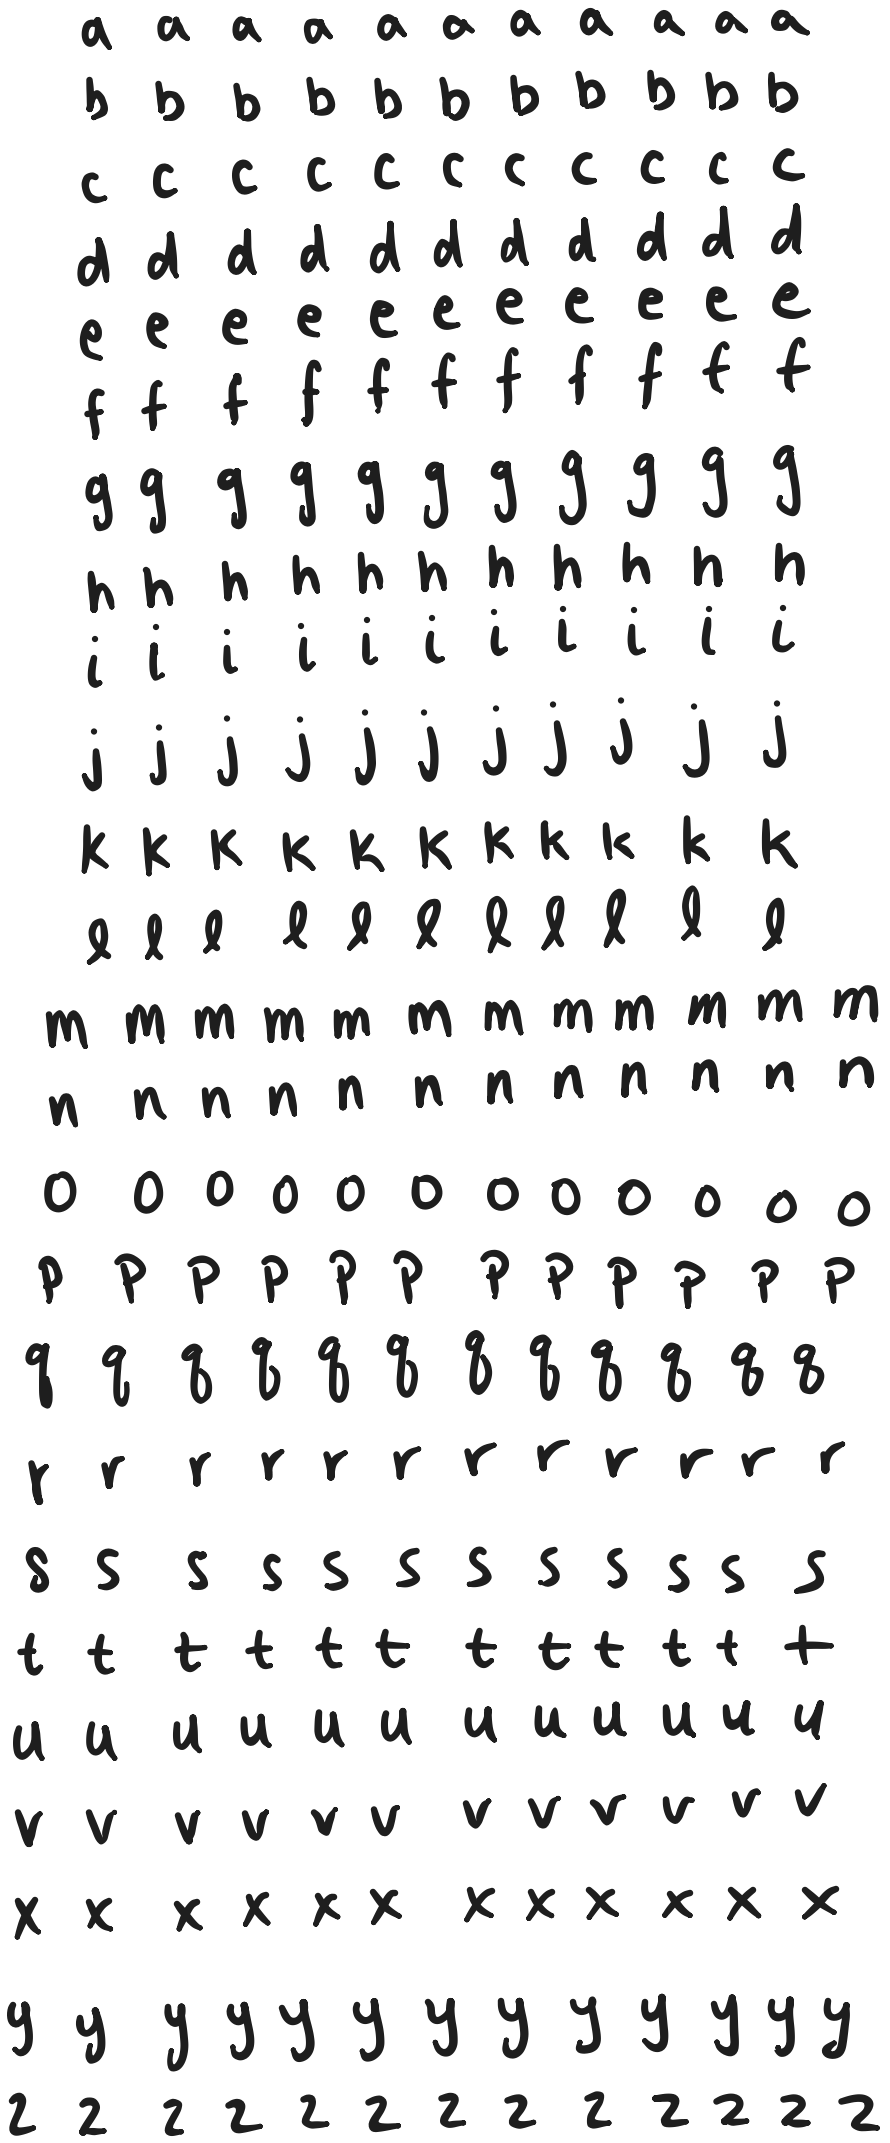

The below code snippet gathers all possible letters of the alphabet and their folders and takes a grouped screenshot and processes them to separate them. The images are first converted to grayscale to reduce computation across 3 color channels to just 1 color channel. The images were then denoised with a Gaussian Blur which helps smooth the images. The image is then passed through a threshold which specifies that a value must be 50% or higher to stay prominent in the image, otherwise it will be removed. This further removes smaller color changes and changes our image to be black and white. Then finally the contours on the image help isolate the photos and are placed in their appropriate folder for later processing. 



In [29]:
all_possible_routes = glob(
            os.path.join("./python/dataset", "**", "image.png"), recursive=True
        )

for route in all_possible_routes:
    image = cv2.imread(route)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(image, (5,5), 0)
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for ITERATION in range(10):
        for index in range(len(contours)):
            try:
                x,y,w,h = cv2.boundingRect(contours[index])
                offset = random.randint(-ITERATION, ITERATION)
                letter = image[y + offset: y + h + offset, x + offset: x + w + offset]
                letter = cv2.resize(letter, (28, 28))
                letter = cv2.bitwise_not(letter)
                os.chdir(route.replace("/image.png", "")) 
                cv2.imwrite(f"{index + len(contours) * ITERATION}.png", letter)
            except:
                pass

os.chdir("../../") 

## Model Preprocessing

Using provided tensorflow functions and utils, the data is split up in a 70/30 ratio for validation for training and validation. The expected input the dataset is 28 pixels by 28 pixels to ensure the model performs consistently. Images by default are also converted to grayscale to prevent having to later convert the images. The classes are stored in a dictionary for easy access later when predicting with the model.

In [30]:
train_datagen = ImageDataGenerator(
    validation_split=0.3,
)

validation_datagen = ImageDataGenerator(
    validation_split=0.3
)

train_generator = train_datagen.flow_from_directory(
    '/Users/shahdivyank/Desktop/codenotes/python/dataset/',
    target_size=(28, 28),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    color_mode="grayscale",
)

validation_generator = validation_datagen.flow_from_directory(
    '/Users/shahdivyank/Desktop/codenotes/python/dataset/',
    target_size=(28, 28),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode="grayscale",
)

class_indices = train_generator.class_indices

classes = dict()

for index in class_indices:
    classes[class_indices[index]] = index

Found 2915 images belonging to 26 classes.
Found 1227 images belonging to 26 classes.


## Model Architecture

The model includes various layers each with a unique purpose. The model enters with a 28 pixel by 28 pixel image which is then passed into a convolutional layer with 16 filters and a kernel size of 3 x 3 and an activiation function of a retified linear unit. The image is then passed through a max pooling filter to reduce the number of features/nodes to compute in further layers. The model continues to go through a 32 filter and 64 filter convolutional filter layer until finally it reaches the final layer where it flattens the results and condenses the results into 128 total classes and then finally into the desired amount of classes with the softmax activiation function. This will provide the probabilities of the various classes and the current image from which the highest probaility can be picked. 

In [31]:
model = Sequential([
	Conv2D(filters=16,
				kernel_size=3, 
				activation="relu", 
				input_shape=(28, 28, 1)),
    MaxPool2D(),
    
	Conv2D(32,  3, activation="relu"),
	MaxPool2D(),
    
	Conv2D(64,  3, activation="relu"),
    MaxPool2D(),
    
	Flatten(),
	Dense(128, activation="relu"),
    Dense(len(classes), activation="softmax")
])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,970 (136.60 KB)

 Trainable params: 34,970 (136.60 KB)

 Non-trainable params: 0 (0.00 B)

## Model Compilation and Fitting

The model is then compiled and ran with a total of 20 epochs. 

In [32]:
model.compile(loss="categorical_crossentropy", 
			optimizer=tf.keras.optimizers.Adam(),
			metrics=["accuracy"])

In [33]:
model.fit(
    train_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_generator,
)

Epoch 1/20


14/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0446 - loss: 16.4459  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2824 - loss: 6.5247 - val_accuracy: 0.9519 - val_loss: 0.2424
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9355 - loss: 0.2765 - val_accuracy: 0.9902 - val_loss: 0.0465
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9755 - loss: 0.0841 - val_accuracy: 0.9935 - val_loss: 0.0392
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9793 - loss: 0.0693 - val_accuracy: 0.9959 - val_loss: 0.0159
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9787 - loss: 0.0518 - val_accuracy: 0.9878 - val_loss: 0.0210
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9888 - loss: 0.0433 - val_accuracy: 0.9853 - val_loss: 0.0248
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9840 - loss: 0.0492 - val_accuracy: 0.9927 - val_loss: 0.0188
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9799 - loss: 0.0474 - val_accuracy: 0.9919 - val_loss: 0.0220
Ep

In [ ]:
model.save("codenotes.keras")

## Testing

The image is then tested on the training data as well as new data and performed fairly well. The new data is first processed in the same way the training data was processed. When visiting new data, the model does get a few results correct. 

't'

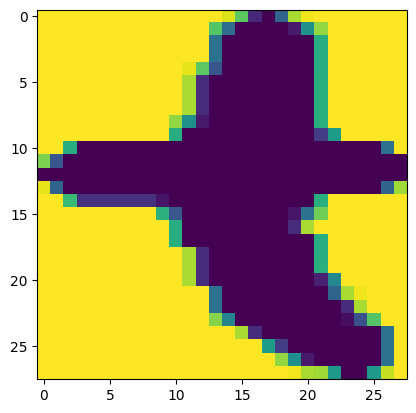

In [35]:
image = cv2.imread("/Users/shahdivyank/Desktop/codenotes/python/dataset/t/5.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image)

image = tf.expand_dims(image, 0)

predictions = model.predict(image, verbose = 0)

predicted_class_name = classes[np.argmax(predictions, axis=1)[0]]

predicted_class_name



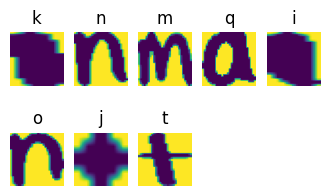

In [36]:
image = cv2.imread("/Users/shahdivyank/Desktop/codenotes/python/sample.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.GaussianBlur(image, (5,5), 0)
ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

fig = plt.figure(figsize=(4,5))

for index in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[index])
    letter = image[y: y + h, x: x + w]
    letter = cv2.resize(letter, (28, 28))

    letter = cv2.bitwise_not(letter)

    fig.add_subplot(4, 5, index + 1) 
    plt.imshow(letter)
    plt.axis('off') 
    

    letter = tf.expand_dims(letter, 0)

    predictions = model.predict(letter, verbose = 0)
    predicted_class_name = classes[np.argmax(predictions, axis=1)[0]]

    plt.title(predicted_class_name)
